# Génération de mélodies allemandes avec un LSTM (dataset "deutsch")

In [1]:
import os
import music21 as m21
import json
from datetime import datetime
from preprocessing import *
from training import *

### Paramètres

In [2]:
DATASET_PATH = "../data/deutsch/original_songs"
SAVE_DIR_ENCODED_SONGS = "../data/deutsch/encoded_songs"

SEQUENCE_LENGTH = 64
FILE_DATASET_PATH = "../data/deutsch/file_dataset"
MAPPINGS_PATH = "../data/deutsch/mapping.json"

NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 25
BATCH_SIZE = 64

MODEL_PATH = "../data/deutsch/model_RNN_LSTM-25epochs.keras"

MAPPING_PATH = "../data/deutsch/mapping.json"
SAVE_GENERATED_MELODIES_DIR = "../generated_melodies/RNN-LSTM/deutsch"
seed = "55"

dataIsReady = True # si les données sont déjà encodées dans un fichier texte ou si il faut refaire le pré-traitement

## Préparation des données

In [ ]:
if (not dataIsReady):
    # load les musiques
    print("loading data...")
    songs = load_songs(DATASET_PATH, 10000)
    print(len(songs),"songs loaded")

    # Enelever durées non acceptables
    print("avant filtrage :", len(songs))
    for song in songs:
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            songs.remove(song)
        if len(song.recurse().getElementsByClass(m21.note.Note)) == 0:
            songs.remove(song)
    print("après filtrage :", len(songs))

    # transposer en do majeur
    transposed_songs = []
    for song in songs:
        transposed_songs.append(transpose(song))
    songs[0].show()
    transposed_songs[0].show()

    # Encoder dans un fichier texte
    encoded_songs = []
    for song in transposed_songs:
        encoded_songs.append(encode_song(song))
    
    # sauvegarder dans un fichier texte
    for i, encoded_song in enumerate(encoded_songs):
        save_path = os.path.join(SAVE_DIR_ENCODED_SONGS, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)
    
    create_single_file_dataset(dataset_path = SAVE_DIR_ENCODED_SONGS, file_dataset_path=FILE_DATASET_PATH, sequence_length=SEQUENCE_LENGTH)

    # mapping des symboles
    songs=load(FILE_DATASET_PATH)
    create_mapping(songs, MAPPINGS_PATH) 
    mappings, OUTPUT_UNITS = load_json(MAPPINGS_PATH)
    

else:
    # charger les fichiers déjà prêts
    songs = load(FILE_DATASET_PATH)
    mappings, OUTPUT_UNITS = load_json(MAPPINGS_PATH)

## Entrainement

In [4]:
inputs, targets = generate_training_sequences(64, songs, mappings)

In [25]:
# build the model
model = build_model(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 38)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       302,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,846 (1.19 MB)

 Trainable params: 311,846 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model

history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 292s 51ms/step - accuracy: 0.7701 - loss: 0.8211
Epoch 2/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 275s 49ms/step - accuracy: 0.8100 - loss: 0.5838
Epoch 3/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 288s 51ms/step - accuracy: 0.8270 - loss: 0.5352
Epoch 4/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 299s 53ms/step - accuracy: 0.8344 - loss: 0.5084
Epoch 5/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 293s 52ms/step - accuracy: 0.8391 - loss: 0.4924
Epoch 6/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 295s 52ms/step - accuracy: 0.8458 - loss: 0.4721
Epoch 7/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 284s 50ms/step - accuracy: 0.8500 - loss: 0.4552
Epoch 8/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 302s 53ms/step - accuracy: 0.8539 - loss: 0.4432
Epoch 9/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 293s 52ms/step - accuracy: 0.8575 - loss: 0.4324
Epoch 10/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 295s 52ms/step - accuracy: 0.8608 - loss: 0.4185
Epoch 11/25
5660/5660 ━━━━━━━━━━━━━━━━━━━━ 292s 52ms/step - accuracy: 0.8650 - loss: 0.40

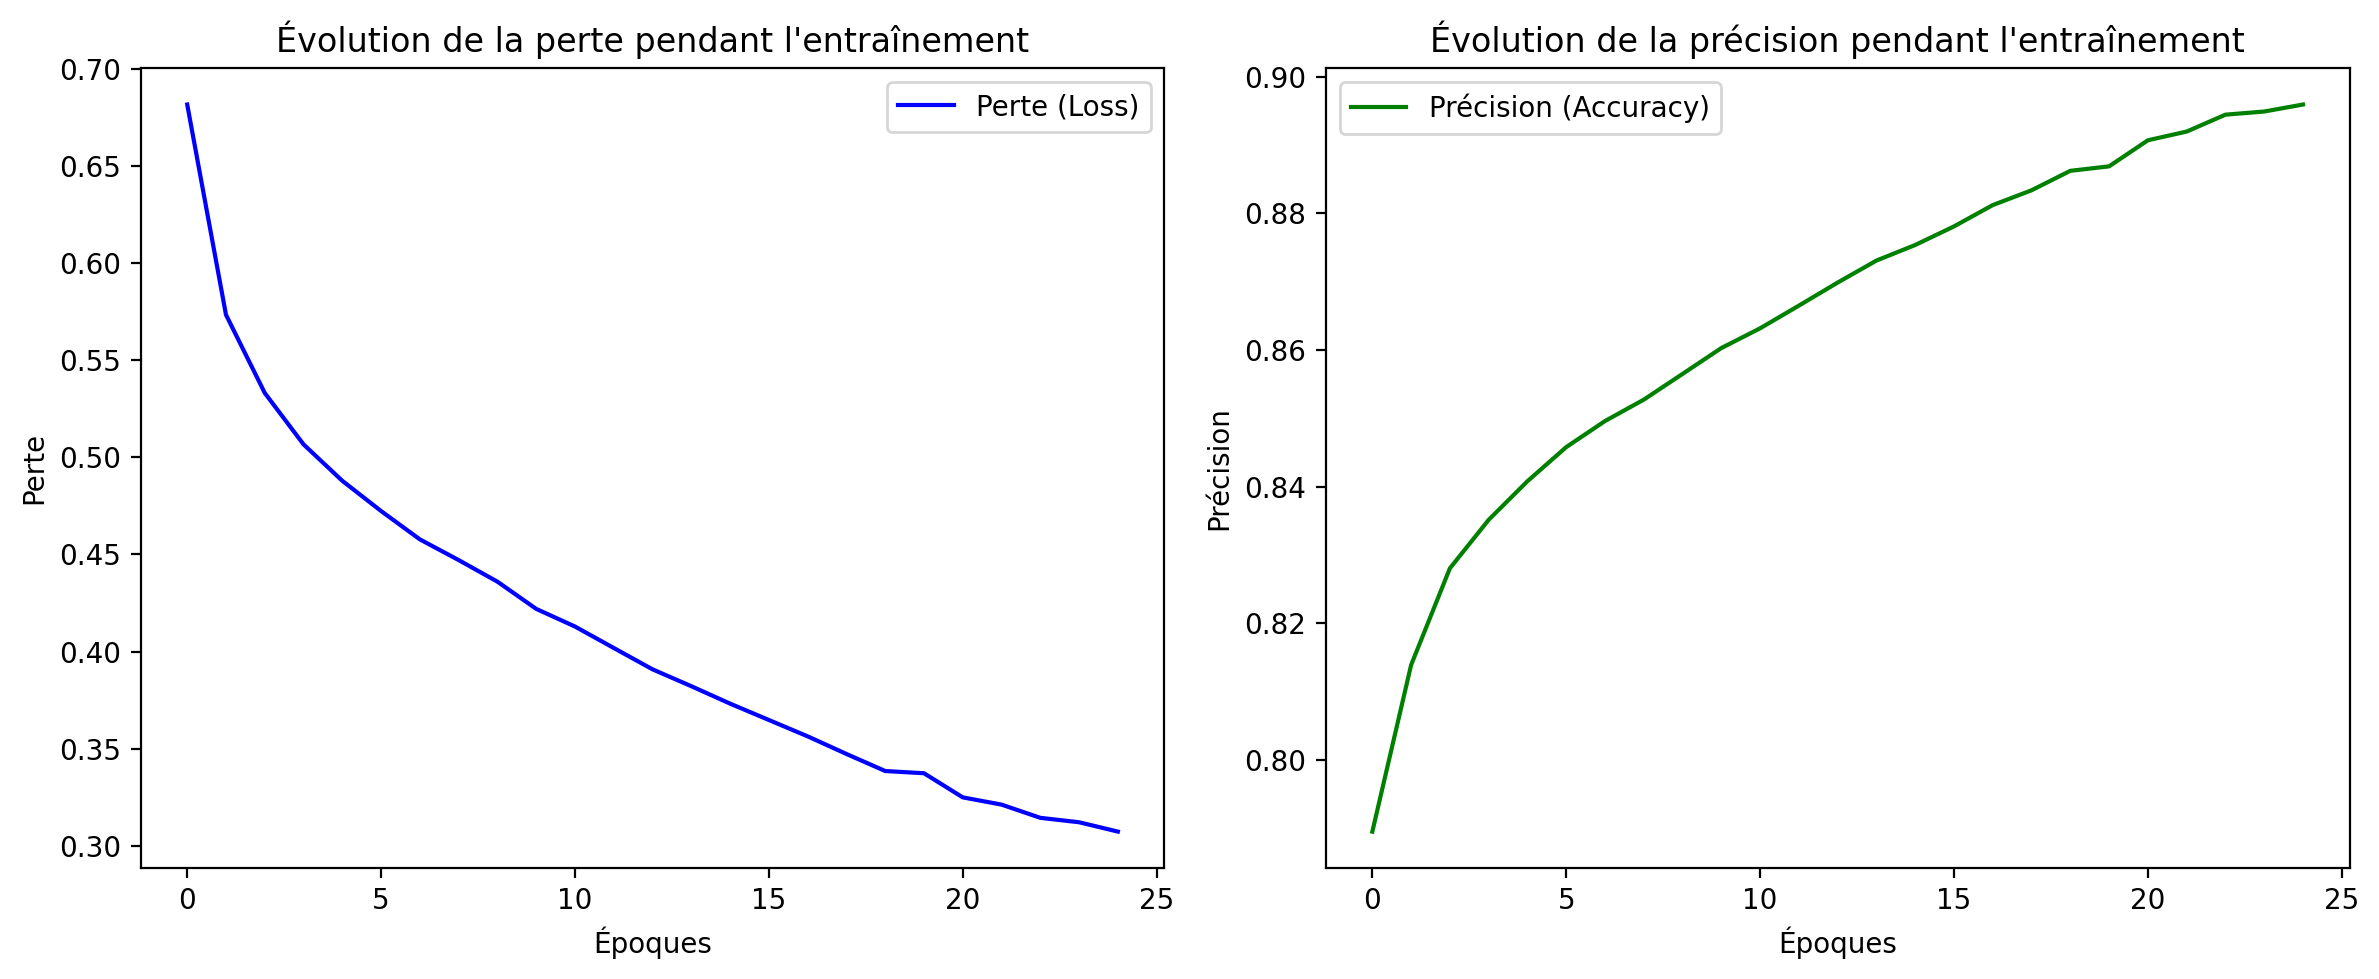

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 : Loss
axs[0].plot(history.history['loss'], label='Perte (Loss)', color='blue')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte')
axs[0].set_title("Évolution de la perte pendant l'entraînement")
axs[0].legend()

# Subplot 2 : Accuracy
axs[1].plot(history.history['accuracy'], label='Précision (Accuracy)', color='green')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Précision')
axs[1].set_title("Évolution de la précision pendant l'entraînement")
axs[1].legend()

# Affichage
plt.tight_layout()
plt.show()

In [28]:
# save the model
model.save(MODEL_PATH)

## Génération de mélodies

In [29]:
# load model
print(MODEL_PATH)
model = keras.models.load_model(MODEL_PATH)

# start symboles
start_symbols = ["/"] * SEQUENCE_LENGTH

# mappings
with open(MAPPING_PATH, "r") as fp:
    mappings = json.load(fp)

../data/deutsch/model_RNN_LSTM-50epochs.keras


In [30]:
# Générer 10 mélodies
melodies = []
for _ in range (10):
    melodies.append(generate_melody(model, start_symbols, mappings, seed, 500, SEQUENCE_LENGTH, 0.7))


print(melodies[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

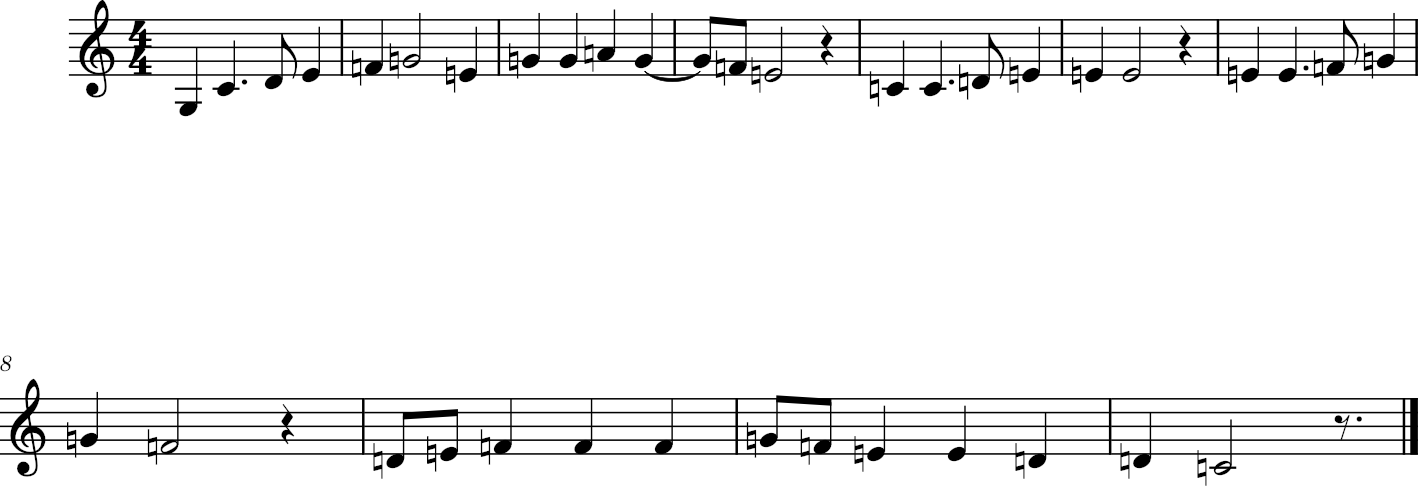

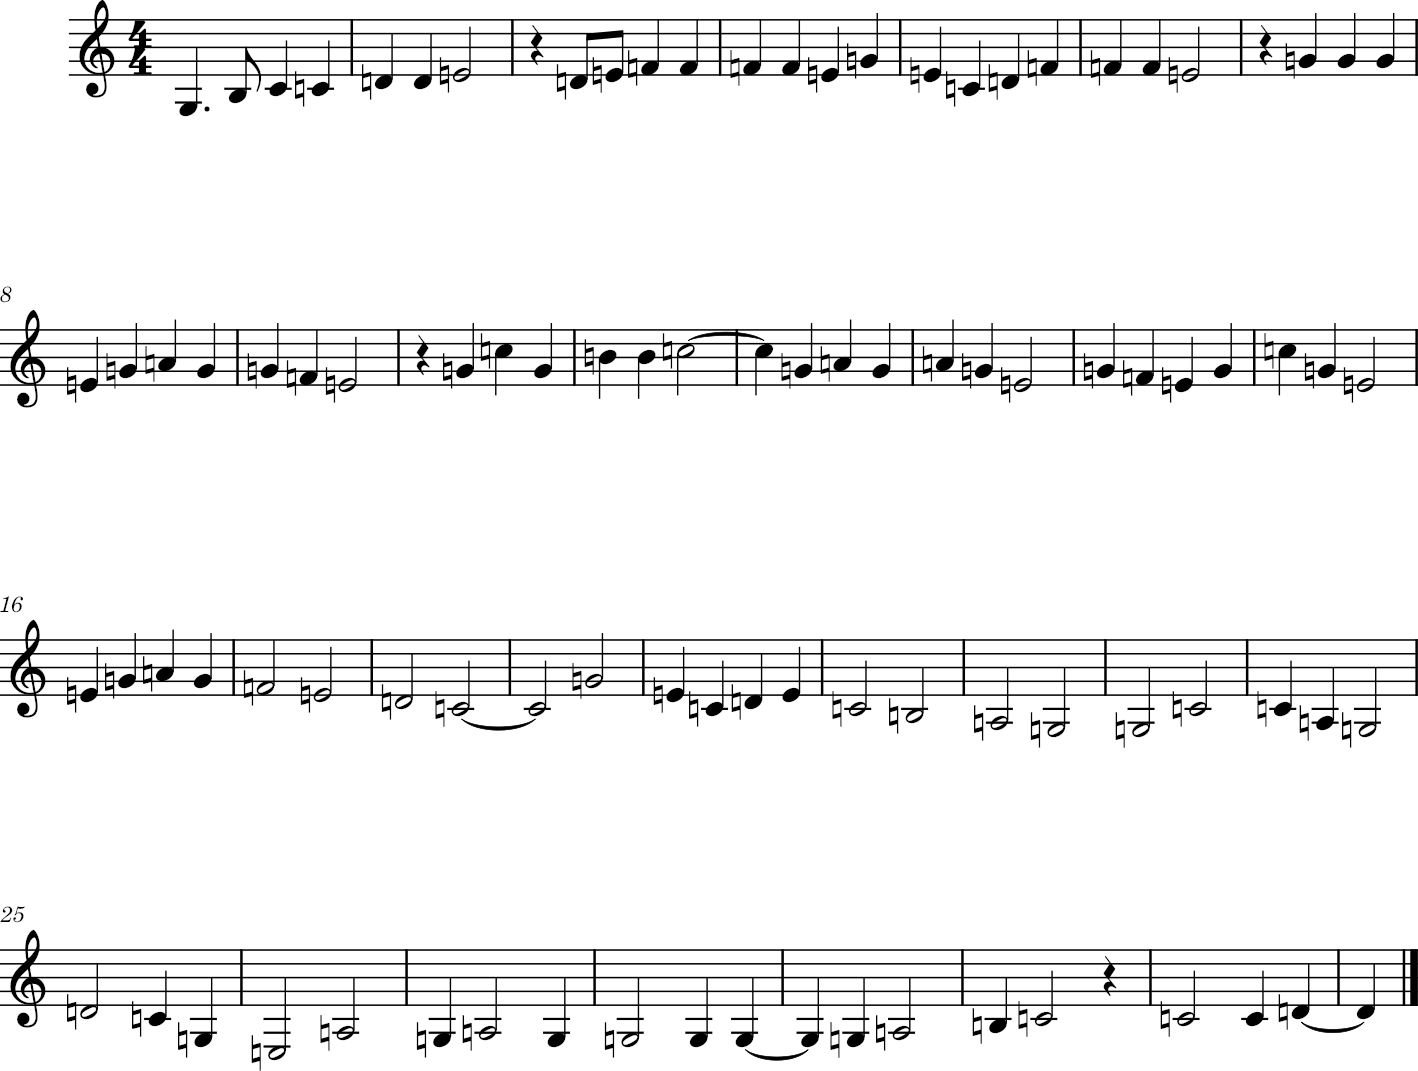

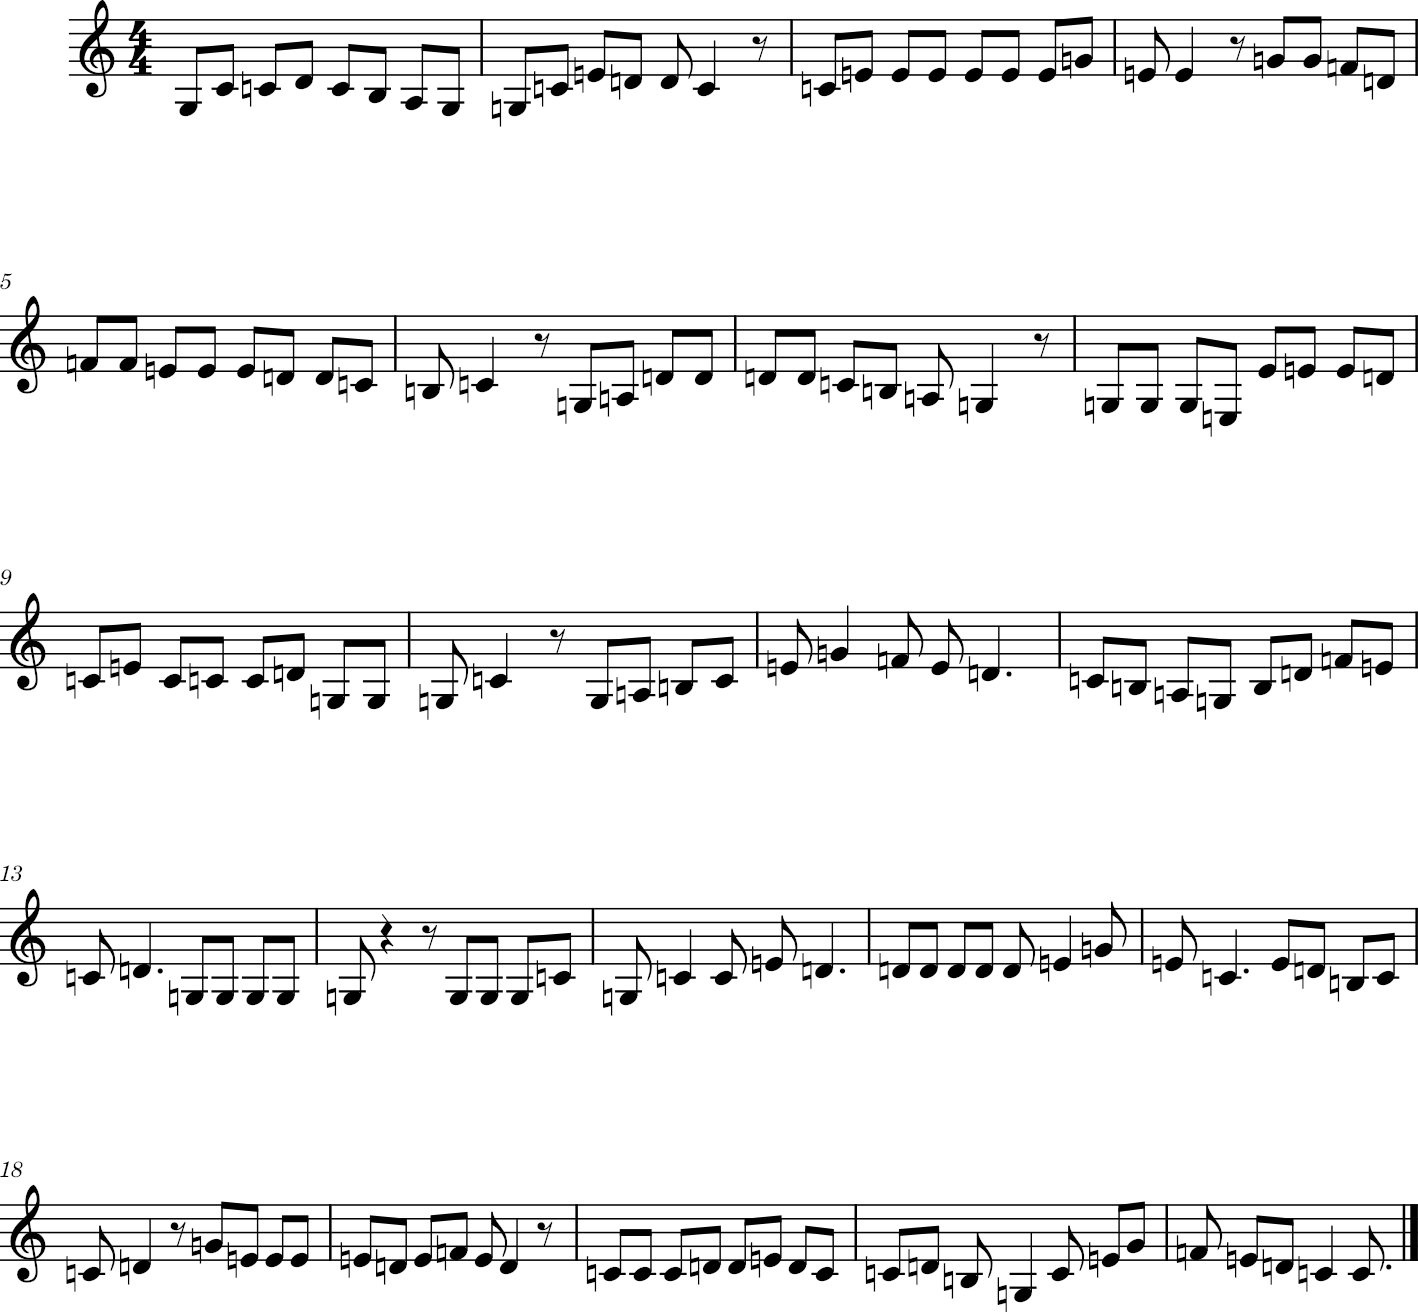

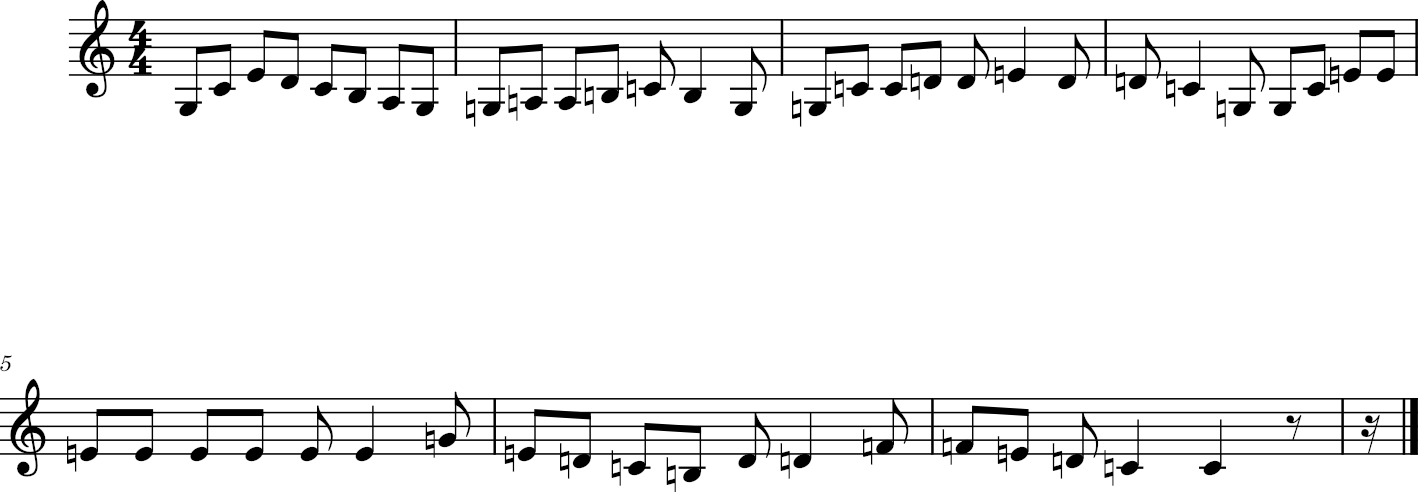

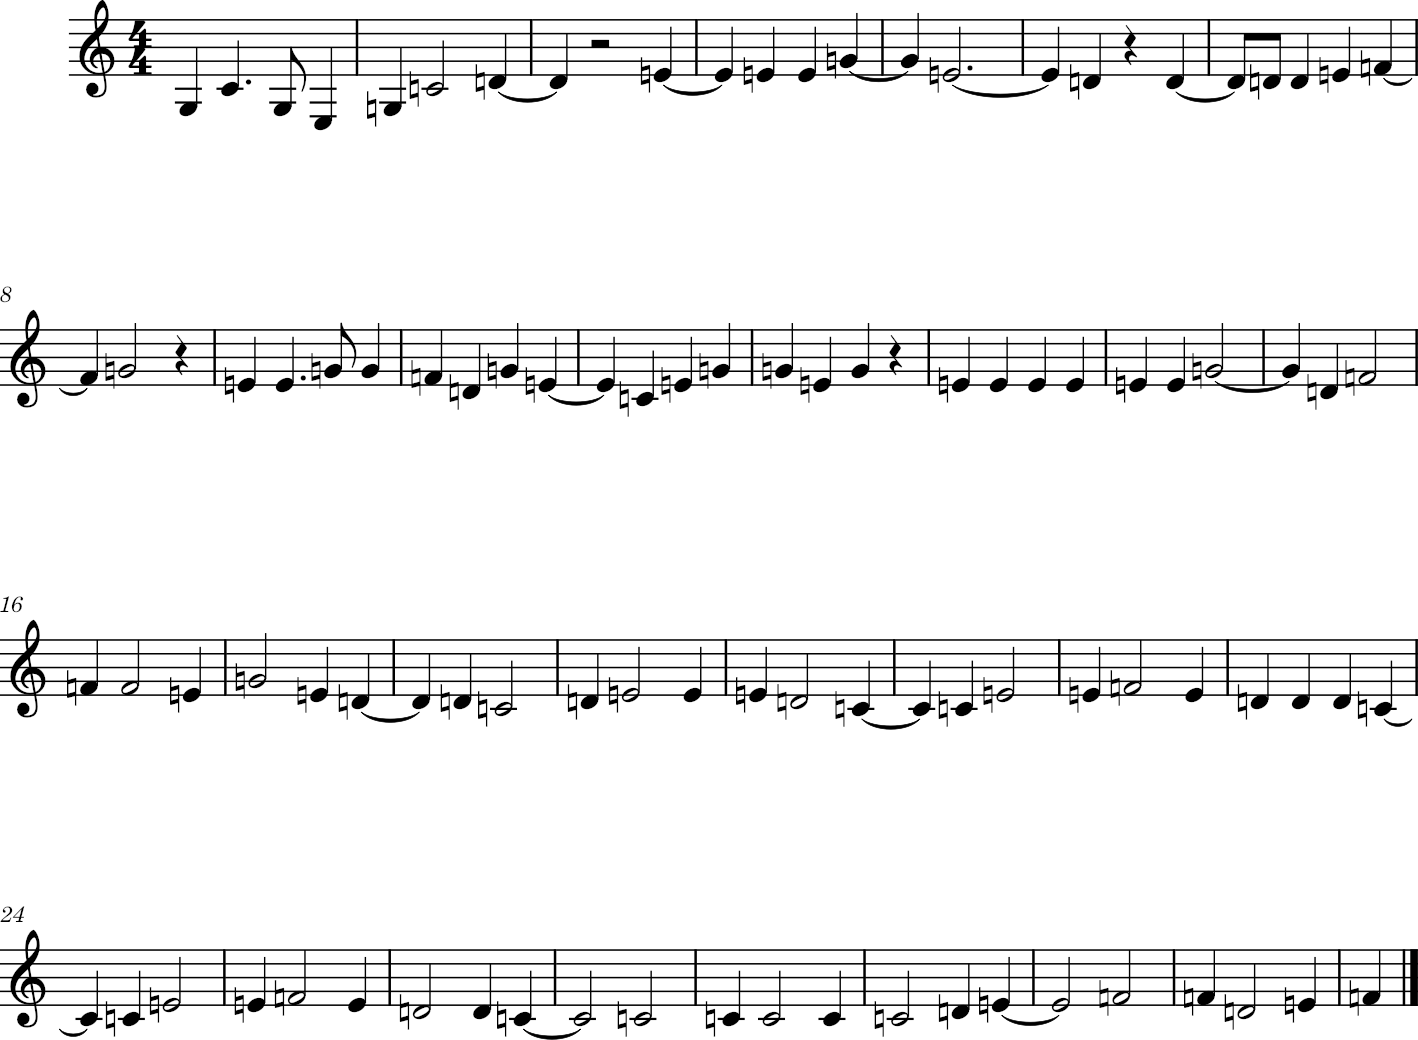

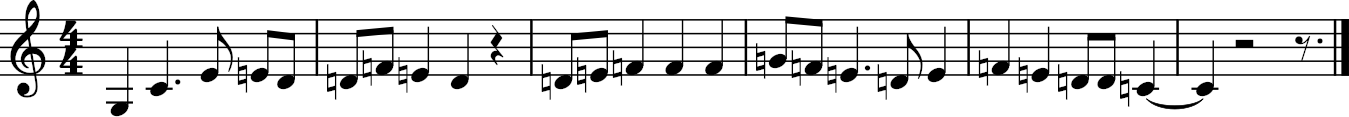

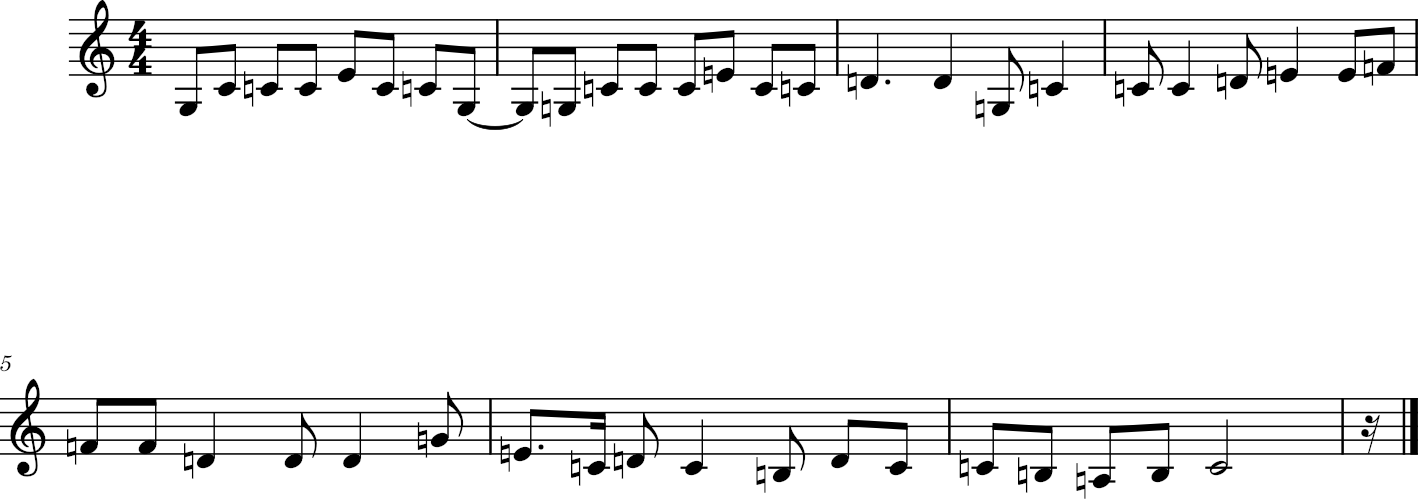

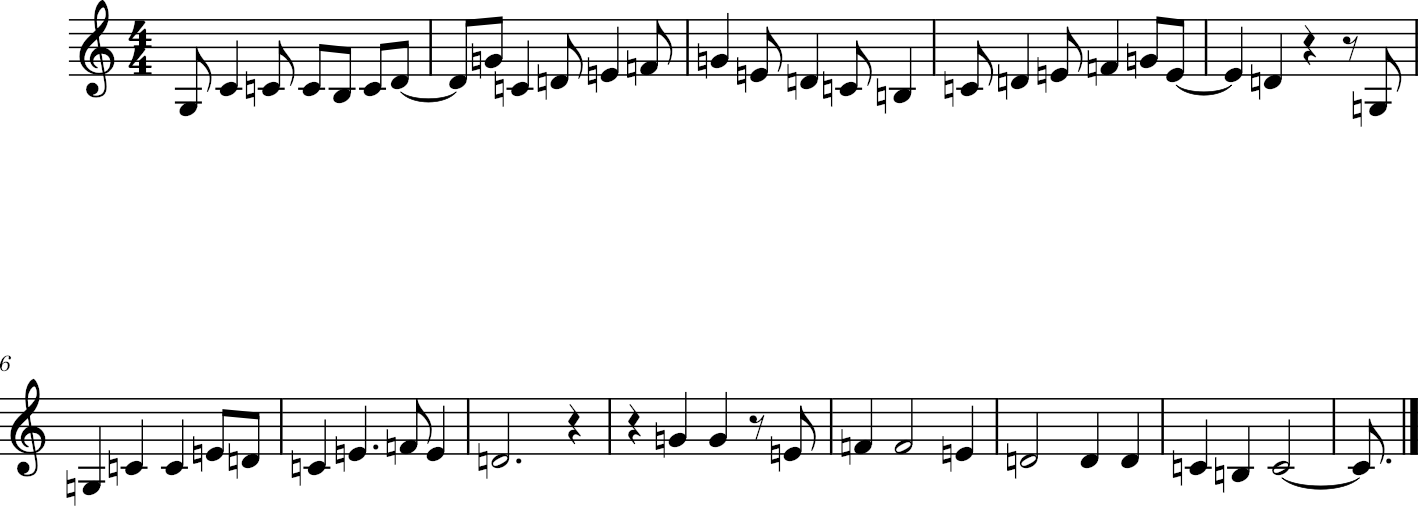

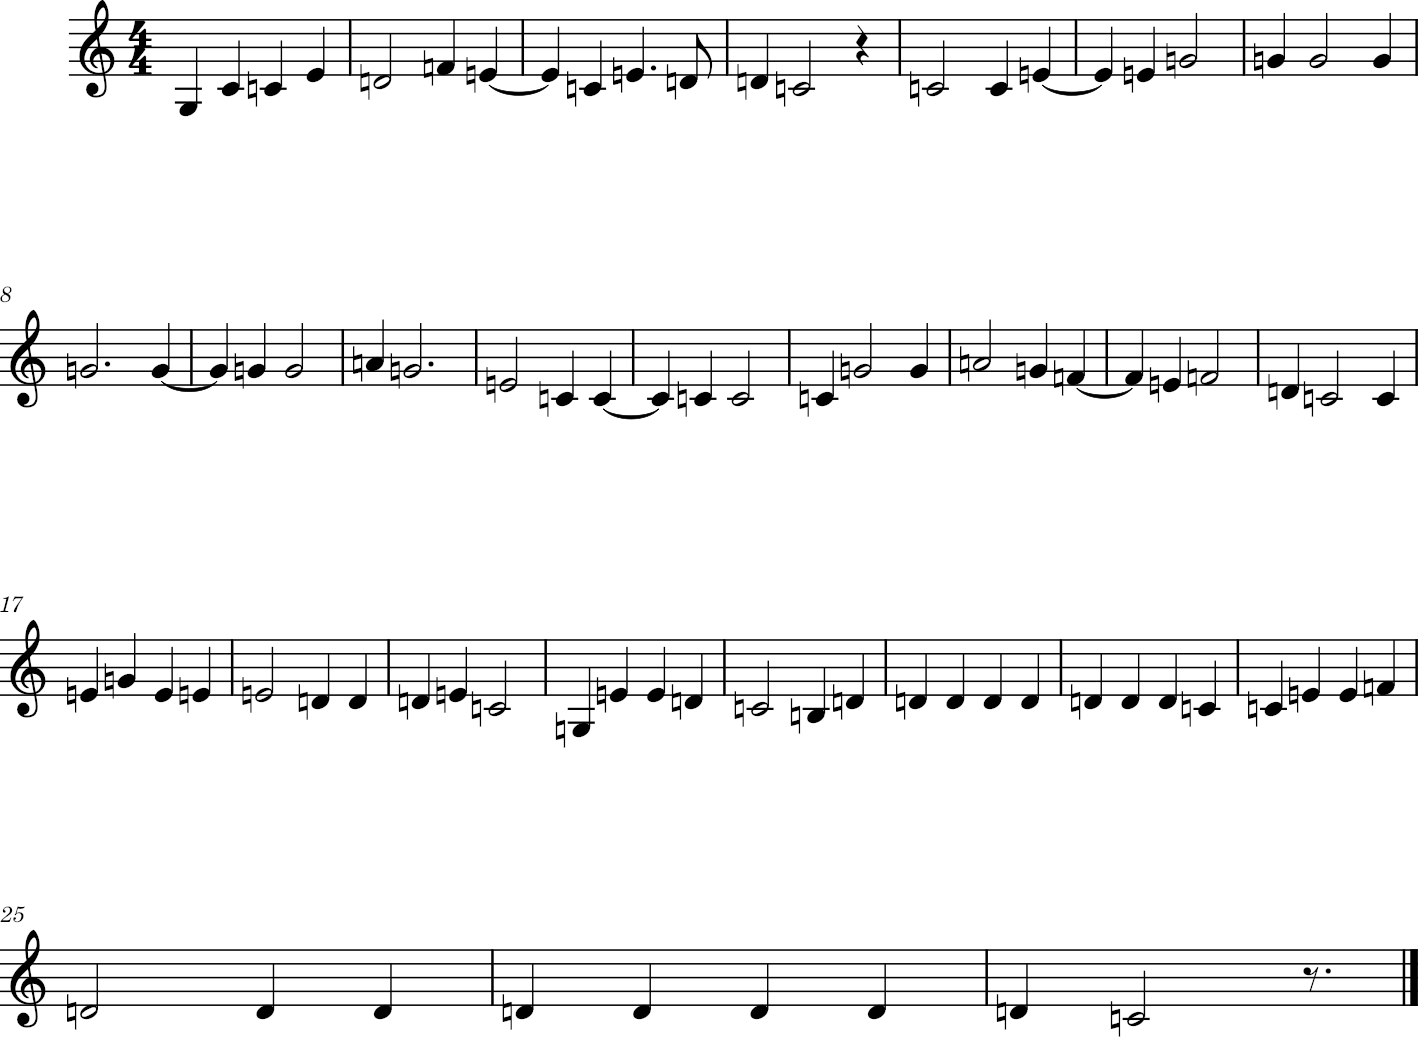

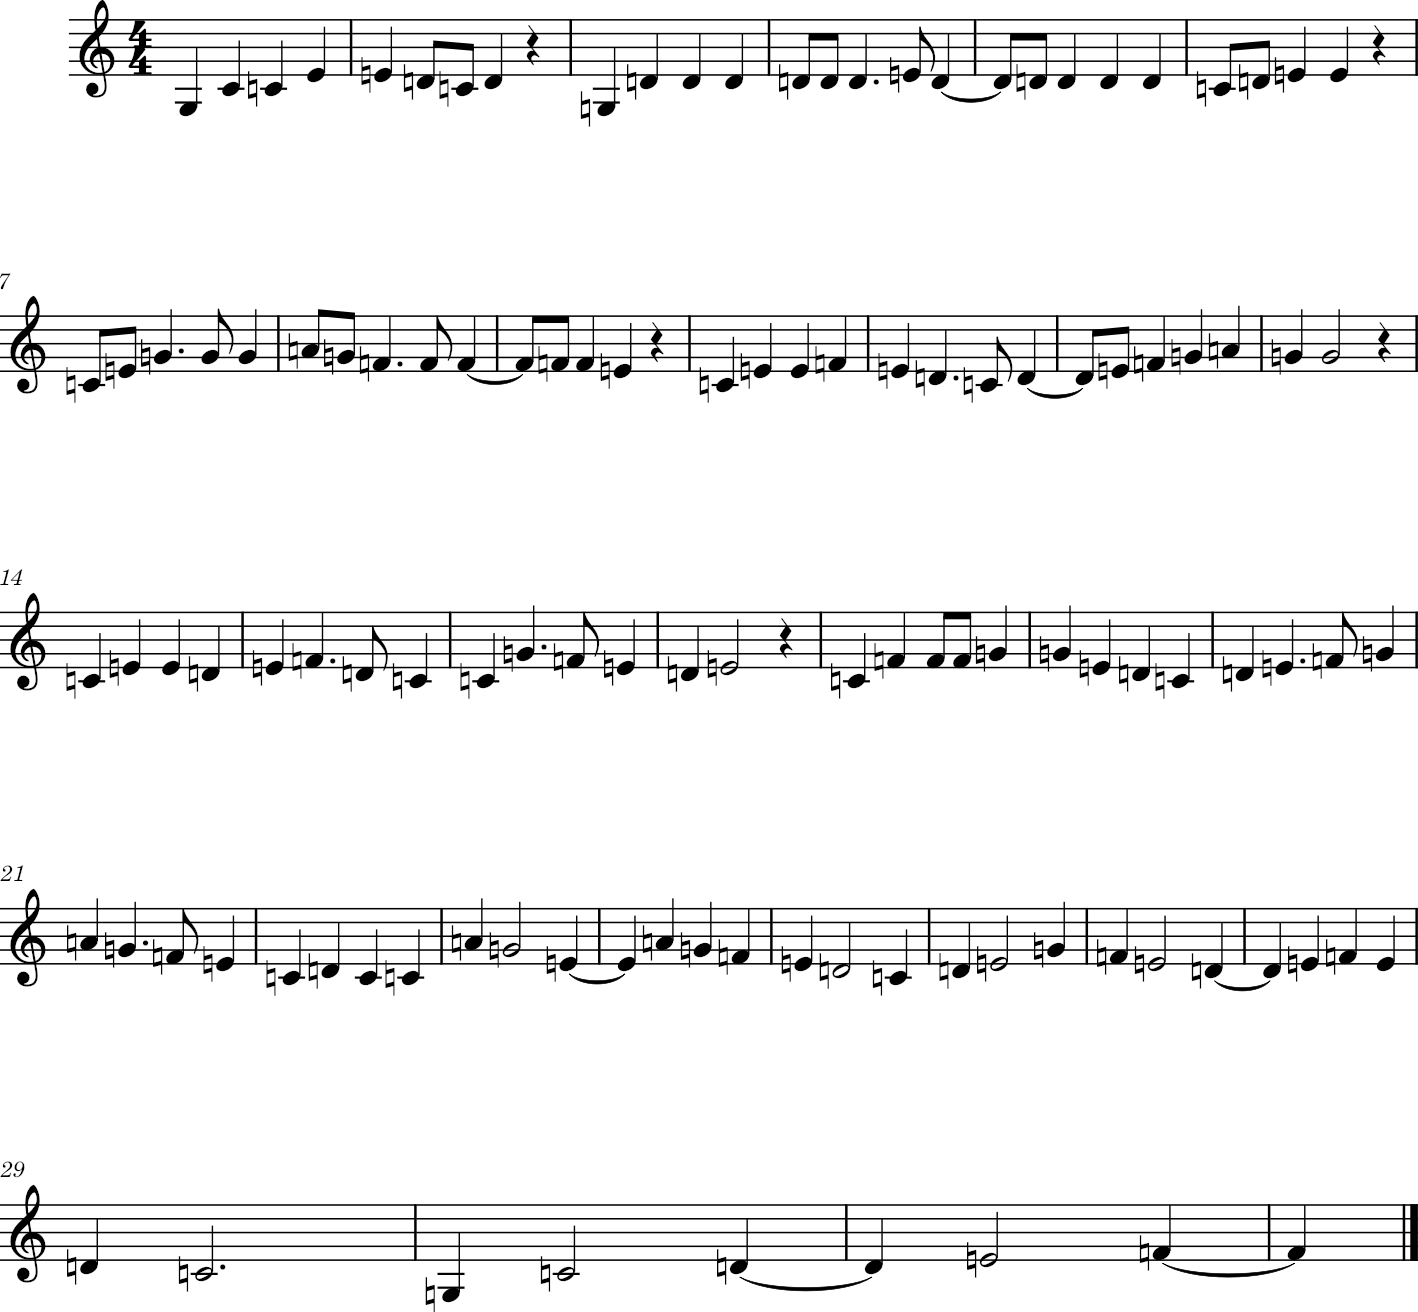

In [31]:
# Les mettre en format midi
songs = []
for i in range(10):
    songs.append(convert_to_midi(melodies[i]))

for song in songs:
    song.show("midi")
    song.show()

In [32]:
# save
timestamp = datetime.now().strftime("%d%m_%H%M%S")  # Format sauvegarde : JJMM_HHMMSS_i
for i in range(10):
    songs[i].write("midi", SAVE_GENERATED_MELODIES_DIR + f"/{timestamp}_{i}.mid")